## **Optimizing LLMs for Inference**

There's mainly three methods up to now.

- Quantization
- Pruning
- Distillation

#### **Quantization**

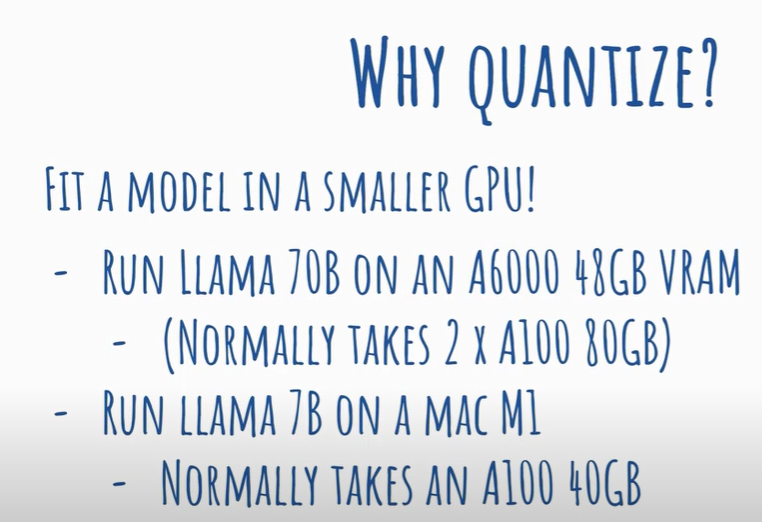

A Large Language Model is represented by a bunch of weights and activations. These values are generally represented by the usual 32-bit floating point (`float32`) datatype.


The number of bits tells you something about how many values it can represent. **Float32** can represent values between 1.18e-38 and 3.4e38. The lower the number of bits, the fewer values it can represent.

<br><br><br>
<div>
<img src="https://i.imgur.com/SIcVjQv.png" width="1000"/>
</div>
<br><br>

`4bit-NormalFloat` (NF4) consists of three steps:
* **Normalization**: The weights of the model are normalized so that we expect the weights to fall within a certain range. This allows for more efficient representation of more common values.
* **Quantization**: The weights are quantized to 4-bit. In NF4, the quantization levels are evenly spaced with respect to the normalized weights, thereby efficiently representing the original 32-bit weights.
* **Dequantization**: Although the weights are stored in 4-bit, they are dequantized during computation which gives a performance boost during inference.

In [ ]:
from transformers import BitsAndBytesConfig
from torch import bfloat16

# Our 4-bit configuration to load the LLM with less GPU memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype = bfloat16  # Computation type
)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Zephyr with BitsAndBytes Configuration
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/zephyr-7b-beta")
model = AutoModelForCausalLM.from_pretrained(
    "HuggingFaceH4/zephyr-7b-beta",
    quantization_config=bnb_config,
    device_map='auto',
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

In [ ]:
prompt = "<|system|>\nYou are a friendly chatbot.</s>\n<|user|>\nTell me a funny joke about Large Language Models.</s>\n<|assistant|>\n"

In [ ]:
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95
)
print(outputs[0]["generated_text"])

There are three types of Quantizations.
- GPTQ 
- GGUF
- AWQ

### **GPTQ**

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load LLM and Tokenizer
model_id = "TheBloke/zephyr-7B-beta-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.


In [12]:
prompt = "<|system|>\nYou are a friendly chatbot.</s>\n<|user|>\nWrite an email to Sam Altman giving reasons to open source GPT-4</s>\n<|assistant|>\n"

In [3]:
%%time
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95
)
print(outputs[0]["generated_text"])

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


<|system|>
You are a friendly chatbot.</s>
<|user|>
Write an email to Sam Altman giving reasons to open source GPT-4</s>
<|assistant|>
Subject: Request for Open Sourcing GPT-4

Dear Sam Altman,

I am writing to express my strong support for the open sourcing of GPT-4, the latest and most advanced iteration of the Generative Pre-trained Transformer (GPT) language model developed by OpenAI. As a leading figure in the tech industry and a proponent of open source principles, I believe that making GPT-4 freely available to the global community would have far-reaching benefits for research, innovation, and societal progress.

Firstly, open sourcing GPT-4 would accelerate the pace of scientific discovery and advancement in the field of artificial intelligence (AI). By making the model's code and training data publicly available, researchers and developers around the world could build upon and improve the model's capabilities, leading to breakthroughs in areas such as natural language processi

### **GGUF**

In [4]:
# Delete any models previously created
del tokenizer, model, pipe

# Empty VRAM cache
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer, pipeline

# Use `gpu_layers` to specify how many layers will be offloaded to the GPU.
model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/zephyr-7B-beta-GGUF",
    model_file="zephyr-7b-beta.Q4_K_M.gguf",
    model_type="mistral", gpu_layers=500, hf=True
)
tokenizer = AutoTokenizer.from_pretrained(
    "HuggingFaceH4/zephyr-7b-beta", use_fast=True
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

In [8]:
prompt = "<|system|>\nYou are a friendly chatbot.</s>\n<|user|>\nWrite an email to Sam Altman giving reasons to open source GPT-4</s>\n<|assistant|>\n"

In [7]:
%%time
outputs = pipe(prompt, max_new_tokens=256)
print(outputs[0]["generated_text"])

<|system|>
You are a friendly chatbot.</s>
<|user|>
Write an email to Sam Altman giving reasons to open source GPT-4</s>
<|assistant|>
Subject: Request for Open Sourcing GPT-4

Dear Mr. Sam Altman,

I am writing to you today to express my strong support for the open sourcing of GPT-4, the latest and most advanced language model developed by OpenAI. As a technology enthusiast and a strong believer in the power of open source, I believe that making GPT-4 available to the wider community will have a significant positive impact on the industry and society as a whole.

Firstly, open sourcing GPT-4 will accelerate the pace of innovation in the field of natural language processing (NLP). By making the model's code and training data publicly available, researchers and developers will be able to build upon and improve upon the existing technology. This, in turn, will lead to the creation of new and more advanced applications, which will benefit a wide range of industries, from healthcare and fi

### **AWQ**

There are several differences between AWQ and GPTQ as methods but the most important one is that AWQ assumes that not all weights are equally important for an LLM's performance.

In other words, there is a small fraction of weights that will be skipped during quantization which helps with the quantization loss.

As a result, their paper mentions a significant speed-up compared to GPTQ whilst keeping similar, and sometimes even better, performance.

In [9]:
from vllm import LLM, SamplingParams

# Load the LLM
sampling_params = SamplingParams(temperature=0.0, top_p=1.0, max_tokens=256)
llm = LLM(
    model="TheBloke/zephyr-7B-beta-AWQ",
    quantization='awq',
    dtype='half',
    gpu_memory_utilization=.95,
    max_model_len=4096
)

WARNING 12-22 08:31:35 config.py:179] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 12-22 08:31:35 llm_engine.py:73] Initializing an LLM engine with config: model='TheBloke/zephyr-7B-beta-AWQ', tokenizer='TheBloke/zephyr-7B-beta-AWQ', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, quantization=awq, enforce_eager=False, seed=0)
INFO 12-22 08:32:12 llm_engine.py:223] # GPU blocks: 843, # CPU blocks: 2048
INFO 12-22 08:32:16 model_runner.py:394] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-22 08:32:33 model_runner.py:437] Graph capturing finished in 17 secs.


In [10]:
prompt = "<|system|>\nYou are a friendly chatbot.</s>\n<|user|>\nWrite an email to Sam Altman giving reasons to open source GPT-4</s>\n<|assistant|>\n"

In [11]:
%%time
output = llm.generate(prompt, sampling_params)
print(output[0].outputs[0].text)

Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.38s/it]

Subject: Request for Consideration to Open Source GPT-4

Dear Mr. Altman,

I am writing to express my strong support for the open sourcing of GPT-4, the latest iteration of OpenAI's Generative Pretrained Transformer (GPT) language model. As a technology enthusiast and a strong believer in the power of open source software, I believe that making GPT-4 available to the wider community would have numerous benefits for the industry and society as a whole.

Firstly, open sourcing GPT-4 would enable a vast array of developers and researchers to build upon and contribute to the model's development. This would lead to a more diverse and robust ecosystem of applications and use cases, as well as the potential for new breakthroughs in natural language processing (NLP) and related fields.

Secondly, open sourcing GPT-4 would promote transparency and accountability in the development and deployment of AI technologies. This would help to mitigate concerns around the potential negative impacts of AI